## Building a Feed-Forward Neural Network

Also, one thing we may consider is divide the attributes into small sets to test which ones are best fit attributes

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dataset = pd.read_csv("Cancer_Data.csv")
print(dataset)

print("Dataset :")
print(dataset.head())
print("Diagnosis : ")
print(dataset['diagnosis'].unique())

print("Dimensions of the dataset : ", dataset.shape)
print("Features of the dataset :")
print(dataset.describe(include = 'all'))
 

           id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0      842302         M        17.99         10.38          122.80     1001.0   
1      842517         M        20.57         17.77          132.90     1326.0   
2    84300903         M        19.69         21.25          130.00     1203.0   
3    84348301         M        11.42         20.38           77.58      386.1   
4    84358402         M        20.29         14.34          135.10     1297.0   
..        ...       ...          ...           ...             ...        ...   
564    926424         M        21.56         22.39          142.00     1479.0   
565    926682         M        20.13         28.25          131.20     1261.0   
566    926954         M        16.60         28.08          108.30      858.1   
567    927241         M        20.60         29.33          140.10     1265.0   
568     92751         B         7.76         24.54           47.92      181.0   

     smoothness_mean  compa

In [42]:
dataset['diagnosis']

0      M
1      M
2      M
3      M
4      M
      ..
564    M
565    M
566    M
567    M
568    B
Name: diagnosis, Length: 569, dtype: object

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

drop_columns = ['diagnosis', 'id', 
                'perimeter_mean', 'area_mean', 'concavity_mean', 'concave points_mean',
                'perimeter_se', 'area_se', 'concavity_se', 'concave points_se', 'fractal_dimension_se',
                'perimeter_worst', 'area_worst', 'concavity_worst', 'concave points_worst', 'fractal_dimension_worst',
                ]

# Pre-process data 
X = dataset.drop(drop_columns, axis=1)
y = dataset['diagnosis']

# Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
X_rescaled = scaler.fit_transform(X)
X = pd.DataFrame(data = X_rescaled, columns = X.columns)


# Binarize
y = y.map({'B': 0, 'M': 1})

# set_of_classes = y.value_counts().index.tolist()
# set_of_classes= pd.DataFrame({'diagnosis': set_of_classes})
# y = pd.get_dummies(y)

# print("Pre-processed data :")
# print(X)

# print("Pre-processed class :")
# print(y)

# #splitting data into ratio 70:30
# data_train, data_test, class_train, class_test = train_test_split(X, y, test_size=0.3)

# Number of nodes in each hidden layer should be (10, 2)
# Learning rate should be 0.4
# Number of epochs should be 600
mlp = MLPClassifier(solver = 'sgd', random_state = 42, activation = 'logistic', learning_rate_init = 0.4, batch_size = 100, hidden_layer_sizes = (10, 2), max_iter = 600)
mlp

MLPClassifier(activation='logistic', batch_size=100, hidden_layer_sizes=(10, 2),
              learning_rate_init=0.4, max_iter=600, random_state=42,
              solver='sgd')

In [44]:
# y = dataset['diagnosis']
# y = pd.get_dummies(y)

In [45]:
# mlp.fit(data_train, class_train)

# pred = mlp.predict(data_test)
# pred
#prediction on the test data. species are represented using the hot-keys

In [46]:
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score

# print("Accuracy : ", accuracy_score(class_test, pred))
# print("Mean Square Error : ", mean_squared_error(class_test, pred))

# print(pred[:5])
# print("Confusion Matrix for each label : ")
# print(multilabel_confusion_matrix(class_test, pred))

# print("Classification Report : ")
# print(classification_report(class_test, pred))

## We use k-fold Cross Validation to validate the FFNN model

https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/#:~:text=The%20key%20configuration%20parameter%20for,evaluate%20models%20is%20k%3D10.

They say k = 10 is the most popular


In [47]:
# Using sklearn function cross_validate()

from sklearn.model_selection import cross_validate

CV = cross_validate(mlp, X, y, cv=8, scoring=['accuracy', 'neg_mean_squared_error'])
print('Accuracy')
print(CV['test_accuracy'])
print('MSE')
print(-1*CV['test_neg_mean_squared_error'])

Accuracy
[0.98611111 0.61971831 0.95774648 0.97183099 0.98591549 0.97183099
 0.98591549 0.95774648]
MSE
[0.01388889 0.38028169 0.04225352 0.02816901 0.01408451 0.02816901
 0.01408451 0.04225352]


In [48]:
print('Average Accuracy = ', sum(CV['test_accuracy']) / len(CV['test_accuracy']))
print('Average MSE = ', sum(-1 * CV['test_neg_mean_squared_error']) / len(CV['test_neg_mean_squared_error']))

Average Accuracy =  0.929601917057903
Average MSE =  0.07039808294209701



Accuracy for batch  1  :  0.19298245614035087
Mean Square Error for batch  1  :  0.8070175438596491

Accuracy for batch  2  :  0.9298245614035088
Mean Square Error for batch  2  :  0.07017543859649122

Accuracy for batch  3  :  0.9649122807017544
Mean Square Error for batch  3  :  0.03508771929824561

Accuracy for batch  4  :  0.9473684210526315
Mean Square Error for batch  4  :  0.05263157894736842

Accuracy for batch  5  :  0.9649122807017544
Mean Square Error for batch  5  :  0.03508771929824561

Accuracy for batch  6  :  0.9824561403508771
Mean Square Error for batch  6  :  0.017543859649122806

Accuracy for batch  7  :  0.9824561403508771
Mean Square Error for batch  7  :  0.017543859649122806

Accuracy for batch  8  :  1.0
Mean Square Error for batch  8  :  0.0

Accuracy for batch  9  :  1.0
Mean Square Error for batch  9  :  0.0

Accuracy for batch  10  :  0.9107142857142857
Mean Square Error for batch  10  :  0.08928571428571429

Average Accuracy =  0.8875626566416039
Average 

c:\Users\Alpha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Alpha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Alpha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

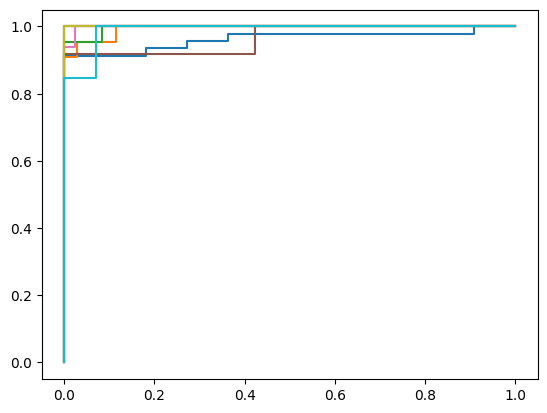

In [49]:
# To find list of accuracy and MSE values
# Without using the sklearn function cross_validate()

from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer

n_splits=10
# step 1: randomize the dataset and create k equal size partitions
kf = KFold(n_splits=n_splits)
models = []

acc = 0
mse = 0

i = 0 #keep track of batch number
# step 5: iterate k times with a different testing subset
for train_indices, test_indices in kf.split(X):

    # step 2-3: use k-1/k^th partition for the training/testing model
    start_train, stop_train = train_indices[0], train_indices[-1]+1
    start_test, stop_test = test_indices[0], test_indices[-1]+1

    X_train, X_test = X[start_train:stop_train], X[start_test:stop_test]
    y_train, y_test = y[start_train:stop_train], y[start_test:stop_test]

    # perform the training similar to Q1
    #this was based on the requirements in Q1
    mlp = MLPClassifier(solver = 'sgd', random_state = 42, activation = 'logistic', learning_rate_init = 0.4, batch_size = 100, hidden_layer_sizes = (10, 2), max_iter = 600)
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    y_prob = mlp.predict_proba(X_test)

    details = {}
    # y_test, y_pred, y_prob
    details["y_test"] = y_test
    details["y_pred"] = y_pred 
    details["y_prob"] = y_prob 
    models.append(details)

    # step 4: record the evaluating scores
    i+=1
    acc += accuracy_score(y_test, y_pred)
    mse += mean_squared_error(y_test, y_pred)

    print("\nAccuracy for batch ", i, " : ", accuracy_score(y_test, y_pred))
    print("Mean Square Error for batch ", i, " : ", mean_squared_error(y_test, y_pred))

# step 6: find the average and select the batch with highest evaluation scores
print('\nAverage Accuracy = ', acc / n_splits)
print('Average MSE = ', mse / n_splits)

# Analyze models
for model in models:
    y_test = model["y_test"]
    y_pred = model["y_pred"]
    y_prob = model["y_prob"]
    
    cmat = confusion_matrix(y_test, y_pred)

    print(f"Confusion Matrix:\n {cmat}")

    # Confusion matrix whose i-th row and j-th column entry indicates the number of 
    # samples with true label being i-th class and predicted label being j-th class.

    tp = cmat[1, 1]
    tn = cmat[0, 0]
    fp = cmat[0, 1]
    fn = cmat[1, 0]

    tpr = tp / (tp + fn) # RECALL/SENSITIVITY 
    print(f"TPR: {tpr}")

    tnr = tn / (tn + fp) # SPECIFICITY
    #tnr = cmat[1][1] / (cmat[1][1] + cmat[0][1])
    print(f"TNR: {tnr}") 

    print(classification_report(y_test, y_pred))

    #fpr0, tpr0, thresholds0 = roc_curve(y_test, y_prob[:, 0])
    #auc0 = roc_auc_score(y_test, y_prob[:, 0])

    fpr1, tpr1, thresholds1 = roc_curve(y_test, y_prob[:, 1])
    auc1 = roc_auc_score(y_test, y_prob[:, 1])

    #plt.plot(fpr0, tpr0)
    # separate these properly later
    plt.plot(fpr1, tpr1)

    #print(f"AUC1 SCORE: {auc0}")
    print(f"AUC1 SCORE: {auc1}")


In [50]:
import pickle

mlp = MLPClassifier(solver = 'sgd', random_state = 42, activation = 'logistic', learning_rate_init = 0.4, batch_size = 100, hidden_layer_sizes = (10, 2), max_iter = 600)
mlp.fit(X, y)
pickle.dump(mlp, open("NN-Model", 'wb'))


In [ ]:
model = pickle.load(open("NN-Model", "rb"))
